In [99]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import the required libraries.
Pandas is used just to read the csv file.

In [100]:
import jax
import jax.numpy as np
import pandas as pd # i am using this only for reading csv file
import matplotlib.pyplot as plt
key = jax.random.PRNGKey(0)
import time
from time import time


Please download the data from [kaggle](https://www.kaggle.com/datasets/oddrationale/mnist-in-csv?select=mnist_train.csv) or [my google drive](https://drive.google.com/file/d/1CsKACdfzN5UGLhiDYawUgyBweQL6bbV1/view)

You should have "mnist_train.csv" in your working directory.

In [101]:
# file= "/content/drive/MyDrive/Colab Notebooks/IIT gandhinagar/MNIST/mnist_train.csv"
file = "mnist_train.csv"
print("loading data from train.csv")
my_data= pd.read_csv(file)
print(my_data.shape)

loading data from train.csv
(60000, 785)


###Split the training and testing data

I have used `train_test_split = 0.3` even though its is asked of us to use `0.8` because 


1.   It takes significantly less time to train on lesser data
2.   It is not hurting the performance (I have observed that there is no underfitting.)

`m` is the no of training examples.



In [102]:
train_test_split = 0.3
                      
train_until = int(my_data.shape[0]*train_test_split)
xtrain, ytrain = my_data.values[:train_until,1:], my_data.values[:train_until, 0]
xtest= my_data.values[train_until:,1:]
ytest= my_data.values[train_until:,0]

m = xtrain.shape[0]


In [103]:
m

18000

###one hot encoding

Encode the output vector. If the digit is say 5, the 6th index of our array will be 1 and all others will be zero.
ie. Y[5] will be 1 and all others will be zero.


In [104]:
Y = np.reshape(np.where(ytrain==0,1,0),(m,1))
for i in range(1,10):
    Y1 = np.reshape(np.where(ytrain==i,1,0),(m,1))
    Y = np.append(Y,Y1,axis=1)

###Visualizing given dataset.

The labels are given as ylabels.

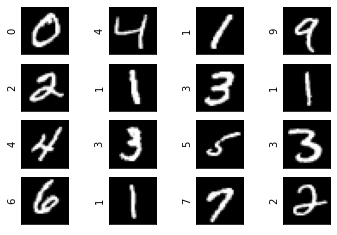

In [105]:
def plot_digit_with_label(img,label):
  fig= plt.figure()
  for i in range(1,17) :
      X = img[i,:]
      X = np.reshape(X, (28,28))
      fig.add_subplot(4,4,i)
      plt.imshow(X , cmap="gray")
      axs = plt.gca()
      axs.xaxis.set_ticks([])
      axs.yaxis.set_ticks([])
      plt.ylabel(str(label[i]))
  plt.show()


img = my_data.values[:18,1:]
label = my_data.values[:18,0]
plot_digit_with_label(img,label)

### Architecture
I have chosen the number of nuerons as follows-



> n0 = 28*28 = 784 (input layer)

> n1 = 128

> n2 = 64

> n3 = 10 (output layer)

Each layer will have a sigmoid activation.


###Initializing the parameters.

the parameters \$W_i\$ corresponding to the 'i' th layer of the network will have dimensions \$[n_i-1,n_i]\$

We will have to do random initialization in order to break the symmetry.

One effective strategy for random initialization is to randomly select values for `W` uniformly in the range [-ϵ,ϵ]. One effective strategy for choosing ϵ is to base it on the number of units in the
network. A good choice of ϵ is 
\begin{equation*}
ϵ = \frac{\sqrt{6}}{\sqrt{n_{in}}+ \sqrt{n_{out}} }
\end{equation*}


In [106]:
def init_mlp_params(layer_widths):
  params = {}
  global key
  i =1
  for n_in, n_out in zip(layer_widths[:-1], layer_widths[1:]):

    key, subkey = jax.random.split(key)
    epsilon_init = np.sqrt(6)/(np.sqrt(n_in)+np.sqrt(n_out))
    params['w'+str(i)]=jax.random.uniform(key,shape=(n_in, n_out)) * 2 * epsilon_init - epsilon_init
    params['b'+str(i)]=np.ones(shape=(n_out,))
    i += 1
  return params

m = xtrain.shape[0]
iterations = 1000
learning_rate = 0.1
# ni = no. of neurons in ith layer.
n0 = xtrain.shape[1]
n1 = 128
n2 = 64
n3 =output = 10
params = init_mlp_params([n0, n1, n2, n3])



### utility funtions.

In [107]:
def sigmoid(Z):
    return (1/(1 + np.exp(-Z)))

def forward_pass(X,W,b):
    """
    executes one foward pass.

    Inputs:
    X-data matrix, W,b parameters

    returns A using sigmoid activation
    """
    Z = np.dot(X,W)+b
    A = sigmoid(Z)
    return Z,A
      
def cost(Y, A, m):
    """
    first parameter is the given labels
    2nd is predicted, 3rd is no of examples
    """
    output = 10
    cost = []
    for i in range(0,output):
        ycap= np.reshape(np.log(A[:,i]),(m,1))
        y = np.reshape(Y[:,i], (m,1))
        cost.append((-1/m)*((np.dot( y.T ,ycap)) +np.dot(1-Y[:,i].T, np.log(1-A[:,i])))[0,0])
    cost = np.array(cost).reshape(1,output)
    return cost

def sigmoidgrad(Z):
    return sigmoid(Z)*(1-sigmoid(Z))
    
def backpass(W2, dz2,Z1,X,m):
    """
    executes backward pass for non-preoutput layer of the 
    layers of the networks
    """
    z1= sigmoidgrad(Z1)
    dz1 = np.dot(dz2,W2.T)*z1
    dw1 = (1/m)*np.dot(dz1.T,X)
    db1 = (1/m)*np.sum(dz1,axis=0,keepdims= True)
    return dz1,dw1,db1
    
def back_prop(A,Y,X,m):
    """
    executes backward pass for preoutput layer of the 
    layers of the networks
    """
    dZ = A - Y
    dw = (1/m)*np.dot( dZ.T,X)
    db = np.sum(dZ,axis=0,keepdims=True)*(1/m)
    return dZ, dw, db

def predict(A):
    """
    A - output from final layer.
    Takes the final layer of neural nets as inputs,
    gives the predication as a digit.
    """
    predicta = np.argmax(A,axis=1)
    return predicta

### Train the model

In [108]:
iterations = 1000
cost_array = []
for i in range(0,iterations):

    # forward Propagation
    Z1, A1 = forward_pass(xtrain,params['w1'],params['b1'])
    Z2, A2 = forward_pass(A1,params['w2'],params['b2'])
    Z3, A3 = forward_pass(A2,params['w3'],params['b3'])

    # keeping track of things.
    if i%30==0:
        end_time= time()
        print("after " +str(i)+" iterations")
        c = cost(Y,A3,m)
        print("cost vector")
        print(c)
        print("total cost")
        cost_array.append(np.sum(c))
        print(np.sum(c))

    # back Propogation
    dz3, params['dw3'], params['db3'] = back_prop(A3,Y,A2,m)
    dz2, params['dw2'], params['db2'] = backpass(params['w3'],dz3,Z2,A1,m)
    dz1, params['dw1'], params['db1'] = backpass(params['w2'],dz2,Z1, xtrain,m)

    # updating the parameters.
    for i in range(1,4):
      params['w'+str(i)] = params['w'+str(i)]- learning_rate*params['dw'+str(i)].T
      params['b'+str(i)] = params['b'+str(i)]- learning_rate*params['db'+str(i)]

after 0 iterations
cost vector
[[0.5589022  0.9425779  1.4905621  1.3915172  1.0594884  0.96833324
  1.1093448  1.7357439  1.2996299  0.98004264]]
total cost
11.536142
after 30 iterations
cost vector
[[0.29162228 0.30797574 0.30863824 0.3153084  0.30220422 0.29054022
  0.3070738  0.30746165 0.30589604 0.3173282 ]]
total cost
3.054049
after 60 iterations
cost vector
[[0.2531933  0.25158772 0.29710674 0.29678425 0.27772552 0.28307593
  0.28517452 0.27263033 0.29349908 0.30021083]]
total cost
2.8109884
after 90 iterations
cost vector
[[0.21124911 0.1941229  0.28151312 0.27263063 0.2487841  0.27319804
  0.25377664 0.23300898 0.27821457 0.27552128]]
total cost
2.5220194
after 120 iterations
cost vector
[[0.17126386 0.14891732 0.262586   0.24534407 0.22008608 0.26043838
  0.21374942 0.19507878 0.26013187 0.25037098]]
total cost
2.2279668
after 150 iterations
cost vector
[[0.1379162  0.11773005 0.23964022 0.2196983  0.19468004 0.24571557
  0.1729214  0.16305113 0.2399778  0.22851978]]
total c

###Loss vs iterations graph

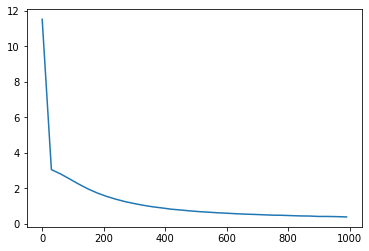

In [113]:
plt.plot(range(0,len(cost_array)*30,30),cost_array)
plt.show()

### Check training set accuracy

In [112]:
Z1, A1 = forward_pass(xtrain,params['w1'],params['b1'])
Z2, A2 = forward_pass(A1,params['w2'],params['b2'])
Z3, A3 = forward_pass(A2,params['w3'],params['b3'])
n= predict(A3)
print("training set accuracy is:")
sum=np.sum(n==ytrain)
print( sum*100/m)

training set accuracy is:
95.494446


### test set accuracy

test set accuracy is:
91.50238

predicted digits with image


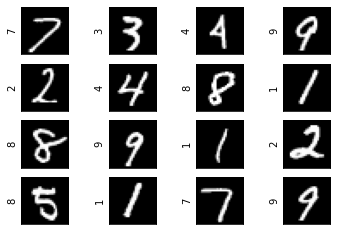

In [114]:

Z1, A1 = forward_pass(xtest,params['w1'],params['b1'])
Z2, A2 = forward_pass(A1,params['w2'],params['b2'])
Z3, A3 = forward_pass(A2,params['w3'],params['b3'])
test_predicted = predict(A3)
print("test set accuracy is:")
sums= np.sum(test_predicted==ytest)
print(sums*100/ytest.shape[0])

img = xtest[5:22]
label = test_predicted[5:22]

print("\npredicted digits with image")
plot_digit_with_label(img,label)

#References



*   [Introduction to machine learning - Andrew Ng](https://www.coursera.org/learn/machine-learning/programming/AiHgN/neural-network-learning)
*   [dataset in csv](https://www.kaggle.com/datasets/oddrationale/mnist-in-csv)


The data is downloaded from Kaggle.

